<a href="https://colab.research.google.com/github/filosoficaguilar/Research_pobreza/blob/main/Pobreza_Energetica_v1_0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installing Libraries

In [ ]:
!pip install geopandas
!pip install matplotlib_scalebar
!pip install mapclassify

##Importing Libraries

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import requests
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

##Getting data First Extraction Only

In [3]:
content = "http://jjsantoso.com/blog/datos/mapa_mexico.zip"
response = requests.get(content)
open("mapa_mexico.zip", "wb").write(response.content)
map_path = ""
with zipfile.ZipFile("mapa_mexico.zip", 'r') as zip_ref:
    zip_ref.extractall(map_path)

In [83]:
mx = gpd.read_file('mapa_mexico/')\
        .set_index('CLAVE')\
        .to_crs(epsg=4485)
mx.head()

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
CLAVE,,,,,,
02004,Tijuana,Baja California,02,004,1122.661145,"POLYGON ((-73565.018 3602427.487, -73564.403 3..."
02003,Tecate,Baja California,02,003,3670.991923,"POLYGON ((-38995.078 3617846.589, -31557.921 3..."
02002,Mexicali,Baja California,02,002,13119.275713,"POLYGON ((48160.716 3621731.593, 58570.990 362..."
02005,Playas de Rosarito,Baja California,02,005,517.120801,"POLYGON ((-70946.724 3594803.753, -70966.034 3..."
26055,San Luis Rio Colorado,Sonora,26,055,9033.770278,"POLYGON ((127160.493 3587762.823, 127099.688 3..."


In [45]:
data = {
    "CVE_EDO": [],
    "CVE_MUNI": [],
    "POPULATION": []
}
url = "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/1002000001/es/070000{}0{}/true/BISE/2.0/bf7b034b-58c5-32c6-4a49-6e1c83bc0858?type=json"
for i,v in mx[["NOM_MUN","NOMEDO","CVE_EDO","CVE_MUNI"]].iterrows():
  r = requests.get(url.format(v["CVE_EDO"],v["CVE_MUNI"]))
  data["CVE_EDO"].append(v["CVE_EDO"])
  data["CVE_MUNI"].append(v["CVE_MUNI"])
  data["POPULATION"].append(r.json()["Series"][0]["OBSERVATIONS"][0]["OBS_VALUE"])

In [54]:
data["CLAVE"] = []
for i,z in zip(data["CVE_EDO"],data["CVE_MUNI"]):
  data["CLAVE"].append("{}{}".format(i,z))

In [74]:
pop = pd.DataFrame.from_dict(data)\
      .assign(CLAVE=lambda x: x['CLAVE'].astype(str).str.zfill(5))\
      .set_index("CLAVE")
pop["POPULATION"] = pop['POPULATION'].astype(float)
pop.head()

,CVE_EDO,CVE_MUNI,POPULATION
CLAVE,,,
02004,02,004,1922523.0
02003,02,003,108440.0
02002,02,002,1049792.0
02005,02,005,126890.0
26055,26,055,199021.0


In [75]:
url = 'https://api.datamexico.org/tesseract/cubes/complexity_eci/aggregate.jsonrecords?cuts%5B%5D=Latest.Latest.Latest.1&drilldowns%5B%5D=Geography+Municipality.Geography.Municipality&drilldowns%5B%5D=Date+Day.Date.Year&measures%5B%5D=ECI&parents=false&sparse=false'
data_eci = requests.get(url).json()
eci = pd.DataFrame(data_eci['data'])\
    .assign(CLAVE=lambda x: x['Municipality ID'].astype(str).str.zfill(5))\
    .set_index('CLAVE')

eci.head()

,Municipality ID,Municipality,Year,ECI
CLAVE,,,,
01001,1001,Aguascalientes,2022,2.895499
01002,1002,Asientos,2022,-0.383386
01003,1003,Calvillo,2022,0.234760
01004,1004,Cosío,2022,-0.523303
01005,1005,Jesús María,2022,2.983224


In [84]:
mx = mx.join(eci, how='left').drop(['Municipality', 'Year'], axis=1)
mx.head()

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry,Municipality ID,ECI
CLAVE,,,,,,,,
01001,Aguascalientes,Aguascalientes,01,001,1168.762384,"POLYGON ((1416489.577 2467700.472, 1417908.226...",1001.0,2.895499
01002,Asientos,Aguascalientes,01,002,547.762077,"POLYGON ((1417043.958 2491681.240, 1417408.488...",1002.0,-0.383386
01003,Calvillo,Aguascalientes,01,003,931.300088,"POLYGON ((1347882.273 2454901.097, 1348002.307...",1003.0,0.234760
01004,Cosio,Aguascalientes,01,004,128.907513,"POLYGON ((1397788.297 2509816.078, 1398009.089...",1004.0,-0.523303
01005,Jesus Maria,Aguascalientes,01,005,499.207990,"POLYGON ((1388272.165 2462097.533, 1389832.232...",1005.0,2.983224


In [85]:
mx = mx.join(pop["POPULATION"], how='left')
mx.head()

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry,Municipality ID,ECI,POPULATION
CLAVE,,,,,,,,,
01001,Aguascalientes,Aguascalientes,01,001,1168.762384,"POLYGON ((1416489.577 2467700.472, 1417908.226...",1001.0,2.895499,948990.0
01002,Asientos,Aguascalientes,01,002,547.762077,"POLYGON ((1417043.958 2491681.240, 1417408.488...",1002.0,-0.383386,51536.0
01003,Calvillo,Aguascalientes,01,003,931.300088,"POLYGON ((1347882.273 2454901.097, 1348002.307...",1003.0,0.234760,58250.0
01004,Cosio,Aguascalientes,01,004,128.907513,"POLYGON ((1397788.297 2509816.078, 1398009.089...",1004.0,-0.523303,17000.0
01005,Jesus Maria,Aguascalientes,01,005,499.207990,"POLYGON ((1388272.165 2462097.533, 1389832.232...",1005.0,2.983224,129929.0


##Generating Backup

In [86]:
mx.to_csv("mex_data.csv")

##Getting data From Backup

In [ ]:
mx = pd.read_csv("mex_data.csv")

##Splitting Data

In [106]:
oax = mx.query('CVE_EDO=="20"')
edos = mx.dissolve(by='CVE_EDO').drop(["NOM_MUN","CVE_MUNI","Municipality ID", "ECI"], axis=1)

In [122]:
url = "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/3108001001/es/070000{}/true/BISE/2.0/bf7b034b-58c5-32c6-4a49-6e1c83bc0858?type=json"
data = []
for i in range(1,33):
  r = requests.get(url.format(str(i).zfill(2))).json()
  data.append(round(float(r["Series"][0]["OBSERVATIONS"][0]["OBS_VALUE"]),6))
edos["ANALPHABETISM"] = data
edos.head()

,geometry,NOMEDO,Area,POPULATION,ANALPHABETISM
CVE_EDO,,,,,
01,"POLYGON ((1426260.748 2436895.070, 1426251.772...",Aguascalientes,1168.762384,948990.0,2.591569
02,"POLYGON ((58570.990 3622195.740, 70313.168 362...",Baja California,53464.685475,443807.0,1.952404
03,"POLYGON ((632870.703 2617665.128, 632920.622 2...",Baja California Sur,18072.999334,73021.0,2.487343
04,"POLYGON ((2563984.558 2096751.625, 2562441.970...",Campeche,2272.485523,59232.0,6.649910
05,"POLYGON ((1256822.187 2820608.602, 1256854.637...",Coahuila,737.258457,1022.0,1.969330


##Mapping

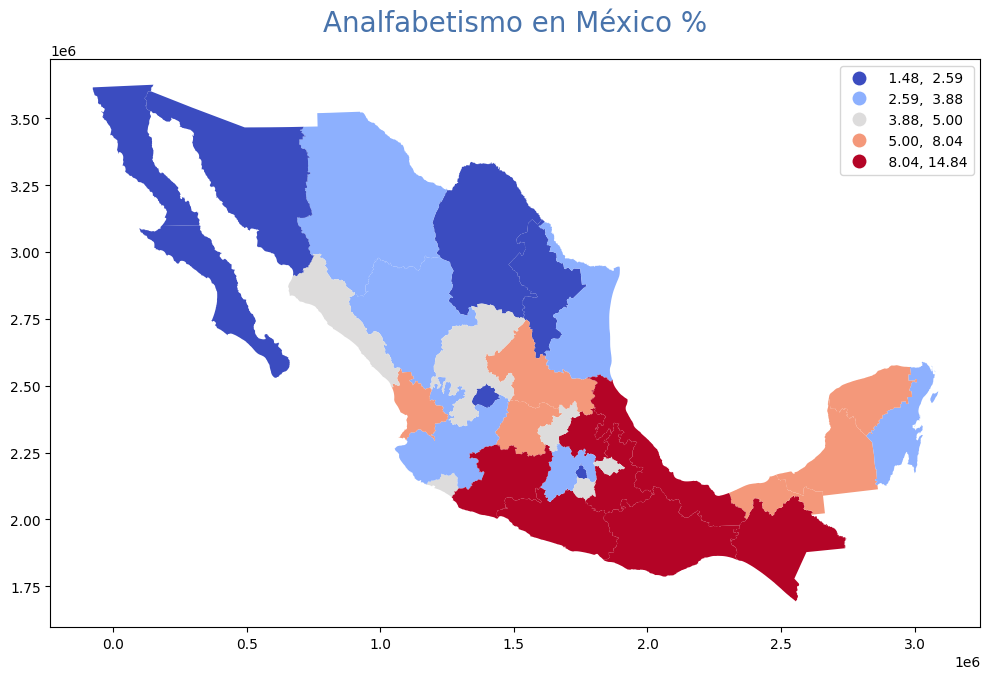

In [134]:
fig, ax = plt.subplots()
edos.plot(column='ANALPHABETISM', legend=True, scheme='quantiles', k=5, cmap='coolwarm', ax=ax)
ax.set_title('Analfabetismo en México %', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
fig.set_size_inches(12, 8)

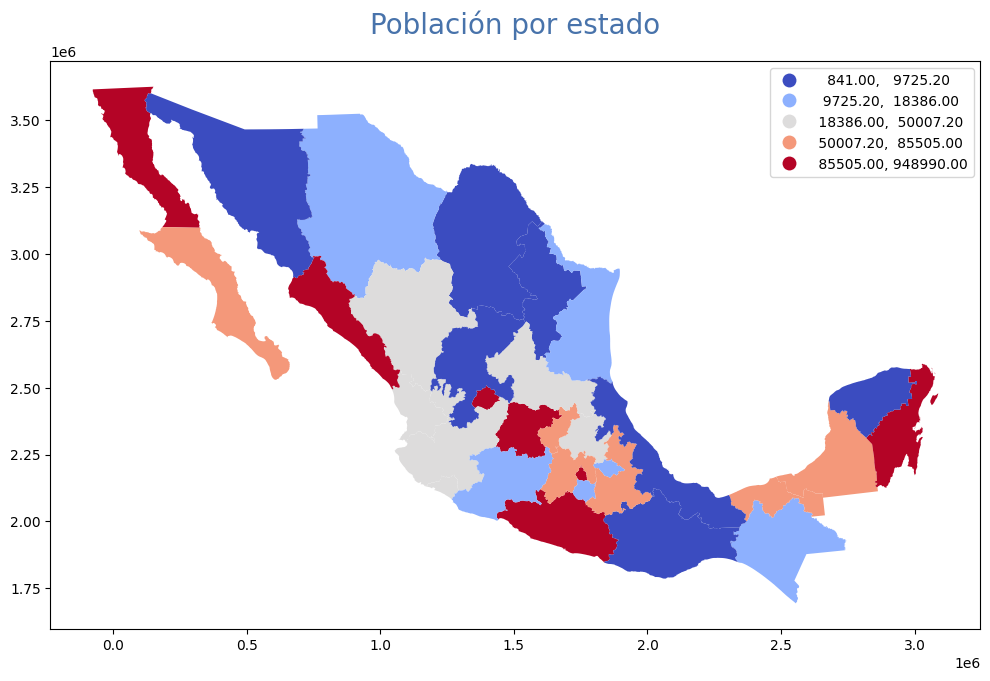

In [135]:
fig, ax = plt.subplots()
edos.plot(column='POPULATION', legend=True, scheme='quantiles', k=5, cmap='coolwarm', ax=ax)
ax.set_title('Población por estado', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
fig.set_size_inches(12, 8)

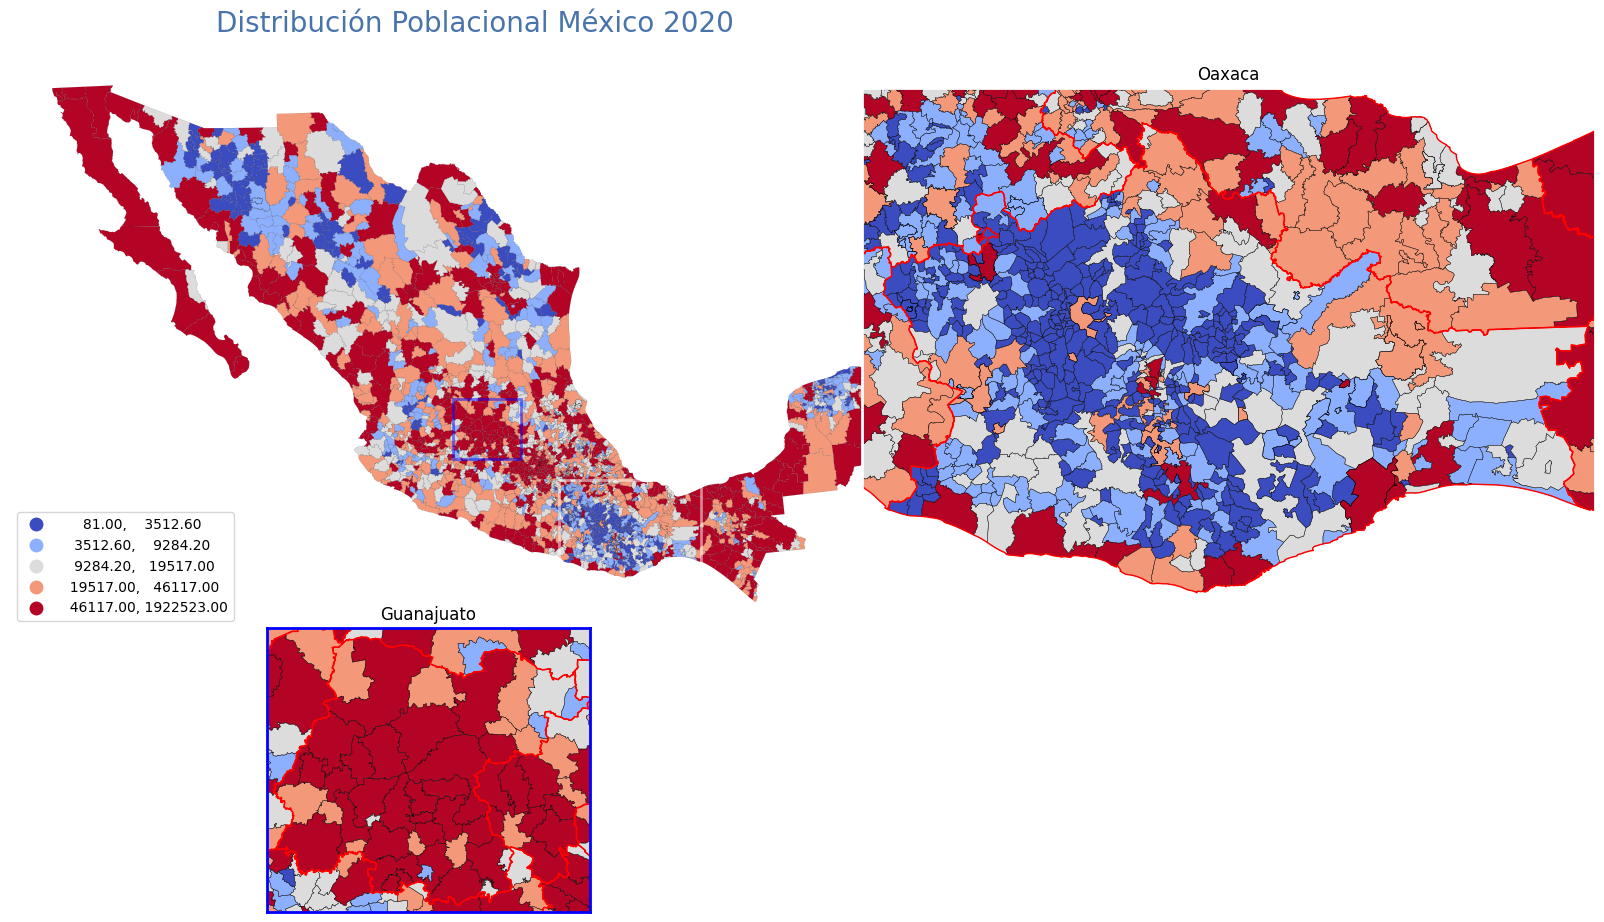

In [126]:
fig, ax = plt.subplots()
# Añade recuadro 1
axins = ax.inset_axes([0.86, 0.05, 0.9, 0.9])
# Añade recuadro 2
axins2 = ax.inset_axes([0.2, -0.5, 0.5, 0.5])

# Gráfica principal
mx.plot(column='POPULATION', legend=True, ax=ax, scheme='quantiles', k=5, cmap='coolwarm', legend_kwds={'loc': 'lower left'})
mx.boundary.plot(lw=0.05, color='k', ax=ax)

# Gráfica recuadro 1
mx.plot(column='POPULATION', legend=False, ax=axins, scheme='quantiles', k=5, cmap='coolwarm')
mx.boundary.plot(lw=0.25, color='k', ax=axins)
edos.boundary.plot(lw=1, color='red', ax=axins)

# Gráfica recuadro 2
mx.plot(column='POPULATION', legend=False, ax=axins2, scheme='quantiles', k=5, cmap='coolwarm')
mx.boundary.plot(lw=0.25, color='k', ax=axins2)
edos.boundary.plot(lw=1, color='red', ax=axins2)

# limita área a mostrar recuadro 1 y 2
axins.set(ylabel='', xlabel='', xlim=(1820000, 2350000), ylim=(1780000, 2150000), xticks=[], yticks=[], title='Oaxaca')
axins2.set(ylabel='', xlabel='', xlim=(1425000, 1680000), ylim=(2229203, 2453767), xticks=[], yticks=[], title='Guanajuato')

# Elimina marco de la gráfica principal
ax.set_axis_off()
# Establece líneas de los recuadros a la gráfica principal
ax.indicate_inset_zoom(axins)
ax.indicate_inset_zoom(axins2)

# Parametros para cambiar colores
color_insets = ['white', 'blue']
color_index = 0

# colorea los cuadros interiores
for p in ax.patches:
    if isinstance(p, plt.matplotlib.patches.Rectangle):
        p.set_edgecolor(color_insets[color_index])
        p.set_linewidth(2)
        color_index += 1
    else:
        # Esconde las líneas hacia la gráfica principal
        p.set_visible(False)

# Colorea el marco del recuadro 1 y aumenta grosor de línea
for sp in axins.spines.values():
    sp.set_color(color_insets[0])
    sp.set_linewidth(2)

# Colorea el marco del recuadro 2 y aumenta grosor de línea
for sp in axins2.spines.values():
    sp.set_color(color_insets[1])
    sp.set_linewidth(2)
    
#Titulo
ax.set_title('Distribución Poblacional México 2020', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
# Tamaño final
fig.set_size_inches(12, 8)

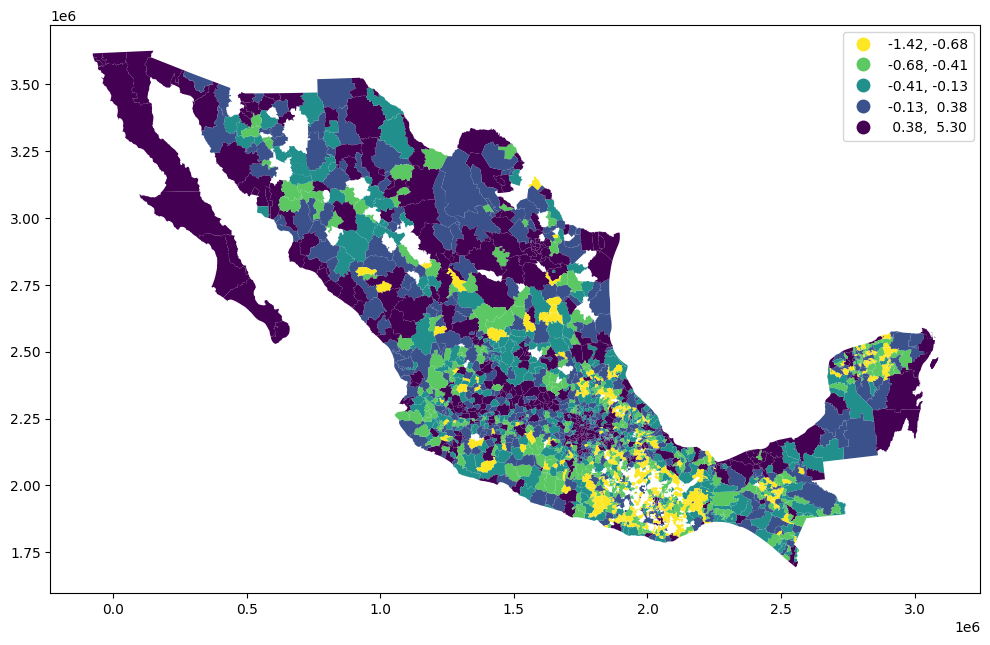

In [94]:
fig, ax = plt.subplots()
mx.plot(column='ECI', legend=True, scheme='quantiles', k=5, cmap='viridis_r', ax=ax)
fig.set_size_inches(12, 8)

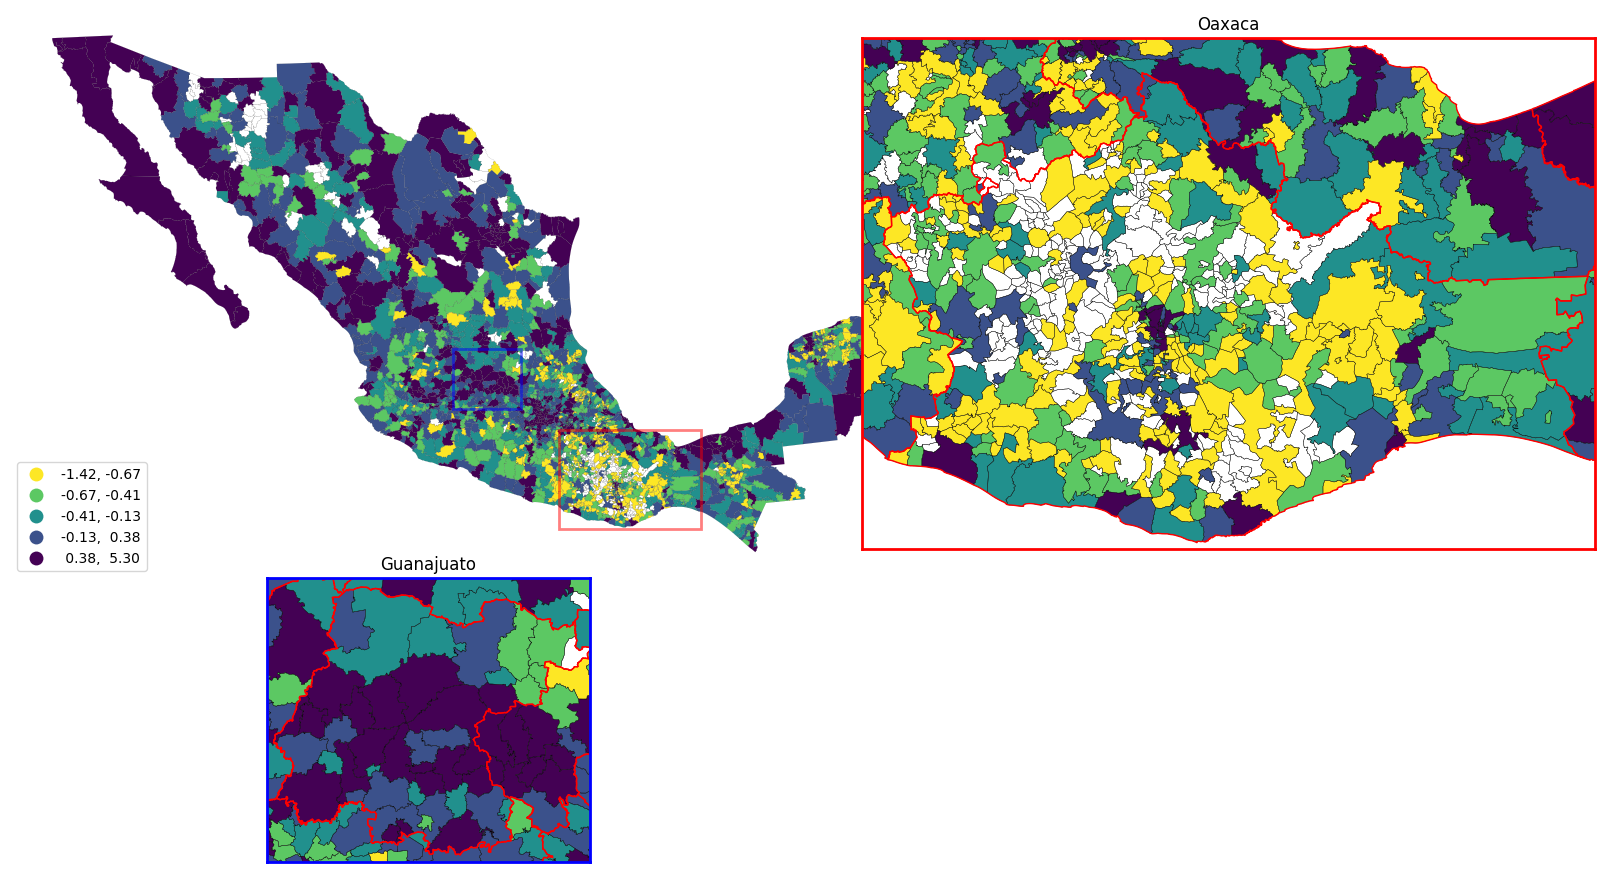

In [ ]:
fig, ax = plt.subplots()
# Añade recuadro 1
axins = ax.inset_axes([0.86, 0.05, 0.9, 0.9])
# Añade recuadro 2
axins2 = ax.inset_axes([0.2, -0.5, 0.5, 0.5])

# Gráfica principal
mx.plot(column='ECI', legend=True, ax=ax, scheme='quantiles', k=5, cmap='viridis_r', legend_kwds={'loc': 'lower left'})
mx.boundary.plot(lw=0.05, color='k', ax=ax)

# Gráfica recuadro 1
mx.plot(column='ECI', legend=False, ax=axins, scheme='quantiles', k=5, cmap='viridis_r')
mx.boundary.plot(lw=0.25, color='k', ax=axins)
edos.boundary.plot(lw=1, color='red', ax=axins)

# Gráfica recuadro 2
mx.plot(column='ECI', legend=False, ax=axins2, scheme='quantiles', k=5, cmap='viridis_r')
mx.boundary.plot(lw=0.25, color='k', ax=axins2)
edos.boundary.plot(lw=1, color='red', ax=axins2)

# limita área a mostrar recuadro 1 y 2
axins.set(ylabel='', xlabel='', xlim=(1820000, 2350000), ylim=(1780000, 2150000), xticks=[], yticks=[], title='Oaxaca')
axins2.set(ylabel='', xlabel='', xlim=(1425000, 1680000), ylim=(2229203, 2453767), xticks=[], yticks=[], title='Guanajuato')

# Elimina marco de la gráfica principal
ax.set_axis_off()
# Establece líneas de los recuadros a la gráfica principal
ax.indicate_inset_zoom(axins)
ax.indicate_inset_zoom(axins2)

# Parametros para cambiar colores
color_insets = ['red', 'blue']
color_index = 0

# colorea los cuadros interiores
for p in ax.patches:
    if isinstance(p, plt.matplotlib.patches.Rectangle):
        p.set_edgecolor(color_insets[color_index])
        p.set_linewidth(2)
        color_index += 1
    else:
        # Esconde las líneas hacia la gráfica principal
        p.set_visible(False)

# Colorea el marco del recuadro 1 y aumenta grosor de línea
for sp in axins.spines.values():
    sp.set_color(color_insets[0])
    sp.set_linewidth(2)

# Colorea el marco del recuadro 2 y aumenta grosor de línea
for sp in axins2.spines.values():
    sp.set_color(color_insets[1])
    sp.set_linewidth(2)
    
# Tamaño final
fig.set_size_inches(12, 8)

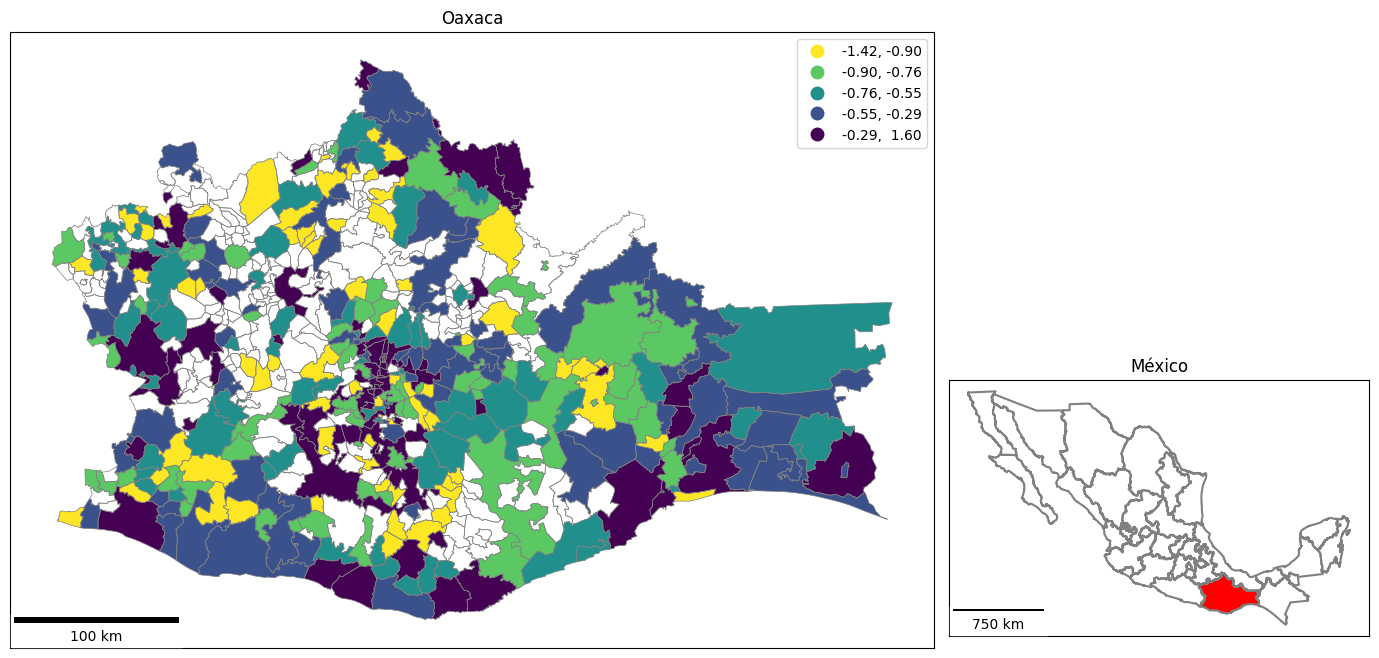

In [ ]:
fig, ax = plt.subplots()
# Mapa principal
oax.plot(column='ECI', legend=True, scheme='quantiles', k=5, cmap='viridis_r', ax=ax)
# Borde de los municipios
oax.boundary.plot(linewidth=0.5, color='gray', ax=ax)
# Inserta recuadro
ax_mex = fig.add_axes([0.91, 0.11, 0.35, 0.35], )
# Dibuja los estados del país en el recuadro
edos.boundary.plot(color='gray', ax=ax_mex)
# Resalta Oaxaca con el color rojo
edos.query('CVE_EDO=="20"').plot(color='red', ax=ax_mex)
# Establece tamaño final
fig.set_size_inches(12, 8)

ax.set(xticks=[], yticks=[], title='Oaxaca')
ax_mex.set(xticks=[], yticks=[], title='México')

# Barras de escala
scalebar_oax = ScaleBar(1, "m", length_fraction=0.2, location='lower left', )
ax.add_artist(scalebar_oax)
scalebar_mex = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax_mex.add_artist(scalebar_mex)